## Importing Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from fastprogress import progress_bar
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


## Data Preprocessing 

In [2]:
# Define paths for train, validation, and test sets
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Define transformations without any augmentation, only resizing, converting to tensor, and normalizing
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for consistency with model input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization 
])

train_augementation = transforms.Compose ([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.RandomRotation(30),  # Randomly rotate images within 30 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Width and height shift (fraction of total size)
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),  # Random zoom (analogous to zoom_range)
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet values
])

# Load datasets from directories 
train_dataset = datasets.ImageFolder(train_dir, transform=train_augementation)
val_dataset = datasets.ImageFolder(val_dir, transform=common_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=common_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

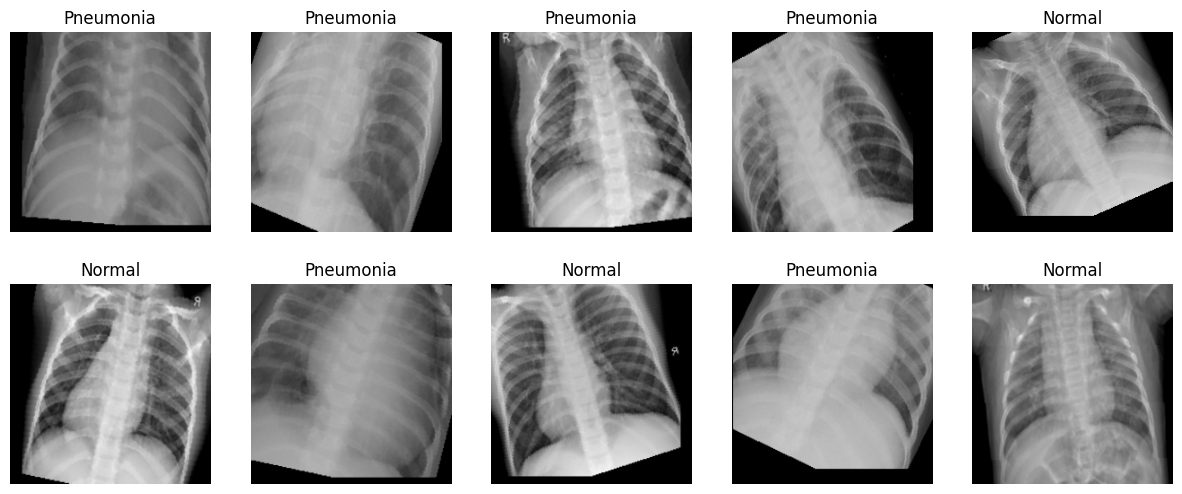

In [3]:
# Get a batch of images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the number of images to display in the grid
num_images = 10
num_cols = 5  # Number of columns in the grid
num_rows = num_images // num_cols  # Calculate rows based on total images

# Display the images in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Convert images to numpy and display
for i in range(num_images):
    ax = axes[i // num_cols, i % num_cols]
    img = images[i].numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to keep them between 0 and 1 for display

    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Pneumonia" if labels[i] == 1 else "Normal")

plt.show()


## Training The Model

### Implementing Resnet-50

In [4]:
# Load the pre-trained ResNet-50 model using the updated weights argument
weights = ResNet50_Weights.IMAGENET1K_V1  
model = resnet50(weights=weights)

# Modify the fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output 1 logit for binary classification
nn.init.xavier_uniform_(model.fc.weight)
# model.fc.bias.fill_(0)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
print(device)

cuda


In [5]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
from torch.utils.data import DataLoader
import torch, time
import torch.functional as F

epochs = 50
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.cpu().item()

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader)}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader)}")


Epoch 1/50, Training Loss: 0.2704316612813005
Validation Loss: 1.420504093170166
Epoch 2/50, Training Loss: 0.1466241606676871
Validation Loss: 0.658179759979248
Epoch 3/50, Training Loss: 0.13064553381795166
Validation Loss: 0.621955394744873
Epoch 4/50, Training Loss: 0.1246783691429836
Validation Loss: 1.503149151802063
Epoch 5/50, Training Loss: 0.12483182957430193
Validation Loss: 0.5392204523086548
Epoch 6/50, Training Loss: 0.11335709063119136
Validation Loss: 0.5361794829368591
Epoch 7/50, Training Loss: 0.10305137413502471
Validation Loss: 0.46178725361824036
Epoch 8/50, Training Loss: 0.10760081549706452
Validation Loss: 0.6857941150665283
Epoch 9/50, Training Loss: 0.09527753829453255
Validation Loss: 0.2963125705718994
Epoch 10/50, Training Loss: 0.08871633826577864
Validation Loss: 0.7422762513160706
Epoch 11/50, Training Loss: 0.09119136778900594
Validation Loss: 0.9083729386329651
Epoch 12/50, Training Loss: 0.09333480908563989
Validation Loss: 0.9735255837440491
Epoch 1

Test Accuracy: 0.9535256410256411
Precision: 0.9640102827763496
Recall: 0.9615384615384616
F1 Score: 0.962772785622593
ROC AUC: 0.9854152969537585


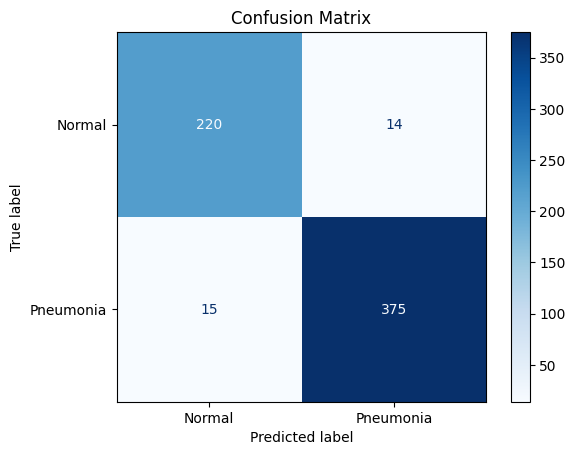

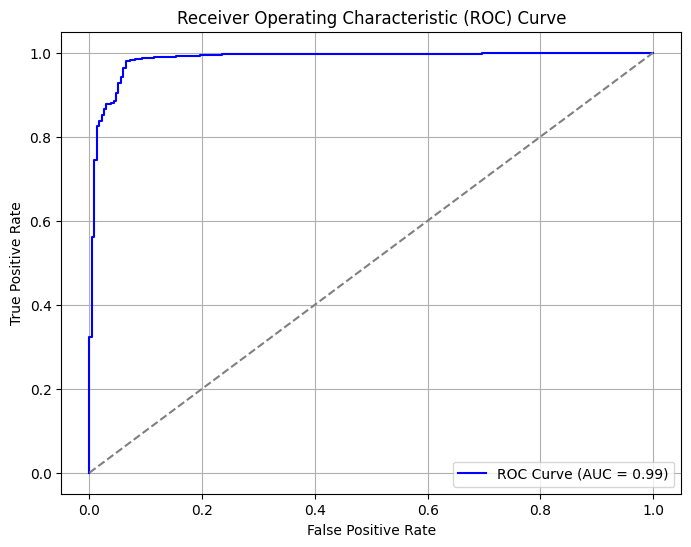

In [ ]:
# Evaluate on the test set
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs).squeeze()  # Apply sigmoid to get probabilities
        preds = (probs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)

        # Store predictions, probabilities, and labels
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for AUC

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)  # Use probabilities for ROC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [14]:
torch.save(model.state_dict(), "pneumonia_resnet50.pth")